In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [2]:
## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Al" 
_path = datapath + "bananas/" + iso
above_path = datapath+ "aboveban/" + iso
cuts1 = datapath + "cuts/totcuts.root"
#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
above_files = glob.glob(os.path.join(above_path, "*mlio.root"))

In [3]:
#### Loading in of the data files storing them in a dictionary
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso: _files,
}
data_collection = {
    iso : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}

for isotope, files in data_files.items():
    #file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), dynamic_ncols=True)
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Al: 100%|██████████ 56/56 [00:22<00:00,  2.45file/s]


In [4]:
## loading in cuts and sorting the data to only look into specific cut regions
totcuts = uproot.open(cuts1)

xsa =[]
ysa =[]
for i in ["abovebanU1", "abovebanU2", "abovebanU3", "blank"]:
    if i=="blank":
        xsa.append(0)
        ysa.append(0)
    else:    
        x, y = totcuts[i].values()
        xsa.append(np.array(x)/1e3)
        ysa.append(np.array(y)/1e3)
xs =[]
ys =[]
for i in ["bananaU1", "bananaU2", "bananaU3", "bananaU4"]:
    
    x, y = totcuts[i].values()
    xs.append(np.array(x)/1e3)
    ys.append(np.array(y)/1e3)
   
in_fedep = []
in_bedep = []
in_E = []
above_events = []
above_fedep = []
above_bedep = []
above_E = []
above_fi = []
above_bi = []
in_fi = []
in_bi = []
in_events = []

isotope = iso
for k, i, j, l, h in zip(range(0,4),xs,ys, xsa, ysa):
    det = f"id{k}"
    inbanana = np.column_stack((i, j))
    inbanana_path = Path(inbanana)
    points = np.column_stack((data_collection[isotope][det]["bEdep"], data_collection[isotope][det]["fEdep"]))
    inmask = inbanana_path.contains_points(points)
    in_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[inmask])
    in_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[inmask])
    in_E.append(np.array(data_collection[isotope][det]["E"])[inmask])
    in_fi.append(np.array(data_collection[isotope][det]["FI"])[inmask])
    in_bi.append(np.array(data_collection[isotope][det]["BI"])[inmask])
    in_events.append(len(in_fedep[k]))
    if k!=3:
        abovebanana = np.column_stack((l, h))
        abovebanana_path = Path(abovebanana)
        abovemask = abovebanana_path.contains_points(points)
        above_E.append(np.array(data_collection[isotope][det]["E"])[abovemask])
        above_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[abovemask])
        above_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[abovemask])
        above_fi.append(np.array(data_collection[isotope][det]["FI"])[abovemask])
        above_bi.append(np.array(data_collection[isotope][det]["BI"])[abovemask]) 
        above_events.append(len(above_fedep[k]))

    else:
        continue
    

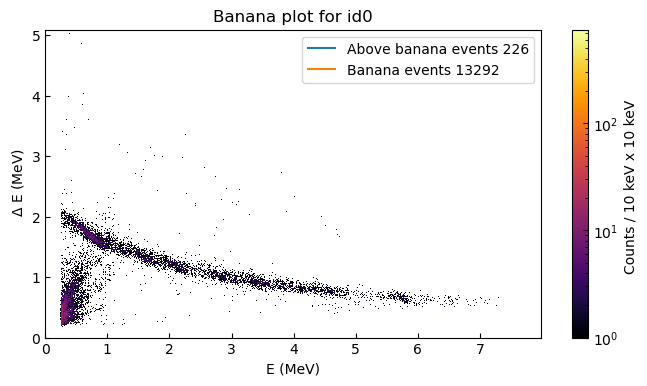

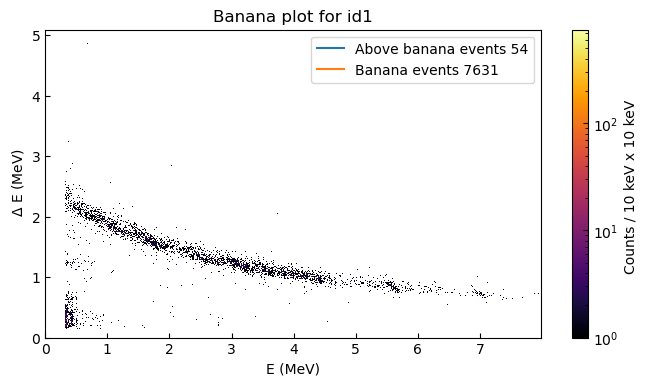

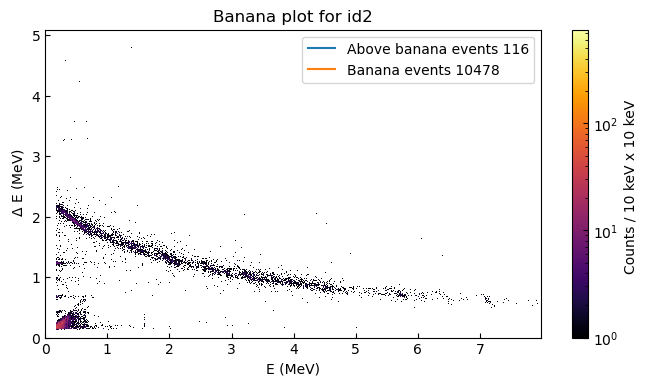

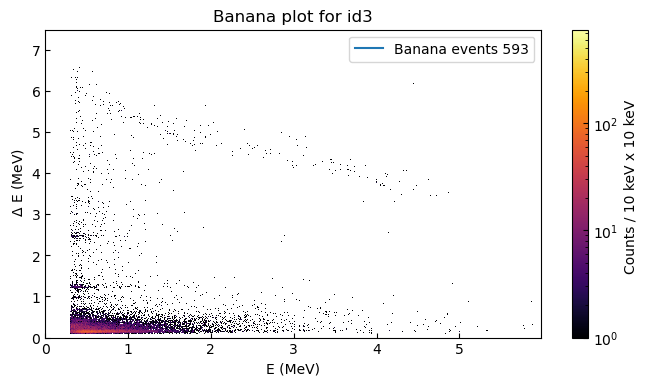

In [8]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

### Banana plots to get an idea of the amount of events above the banana
## An idea of the size of the anomalous events
for i in range(4):
    plt.figure(figsize=(8,4))
    det = f"id{i}"
    if i!=3:
        plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 8, 0.01), np.arange(0, 5.1, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
        plt.plot([], [], label=f"Above banana events {above_events[i]}")
    else:
        plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 6, 0.01), np.arange(0, 7.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)   
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.plot([], [], label=f"Banana events {in_events[i]}")
    plt.legend(loc='upper right')
    plt.xlabel("E (MeV)")
    plt.ylabel(r" $\Delta$ E (MeV)")
    plt.title(f"Banana plot for {det}")

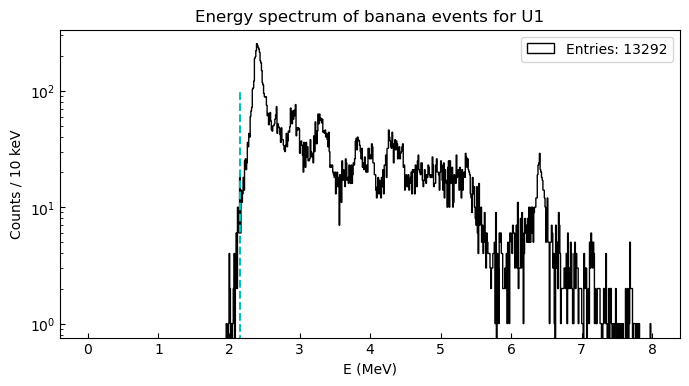

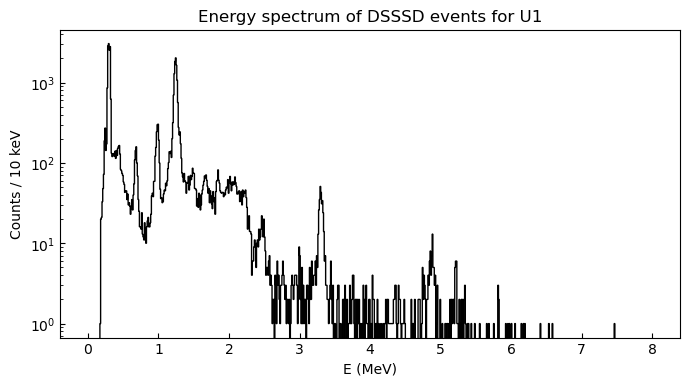

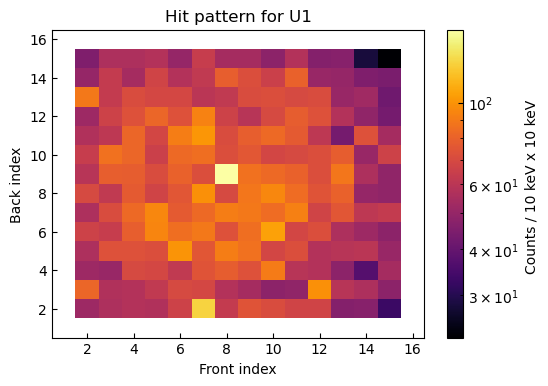

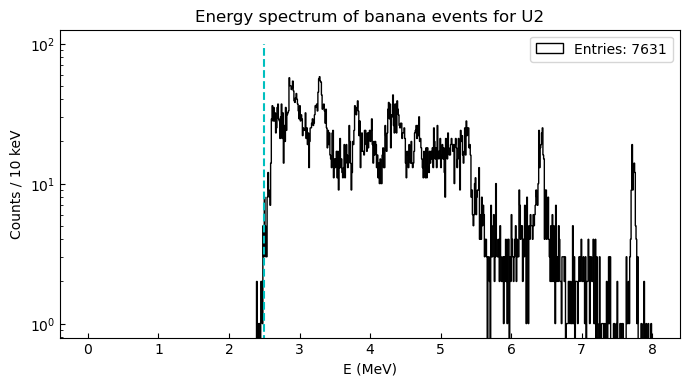

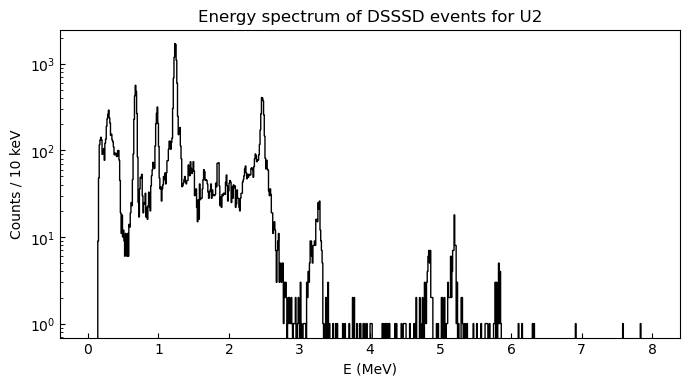

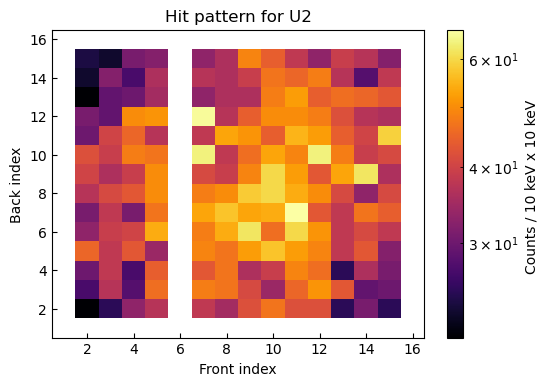

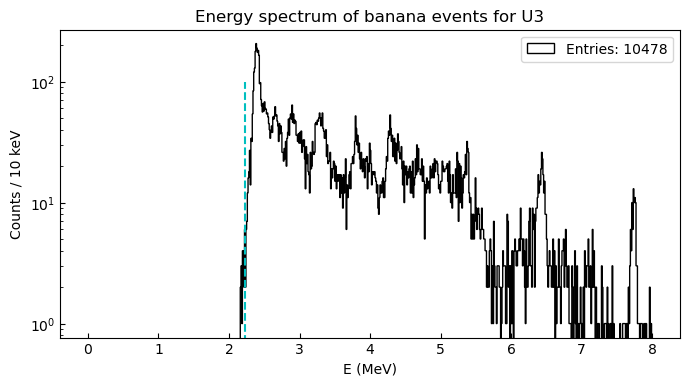

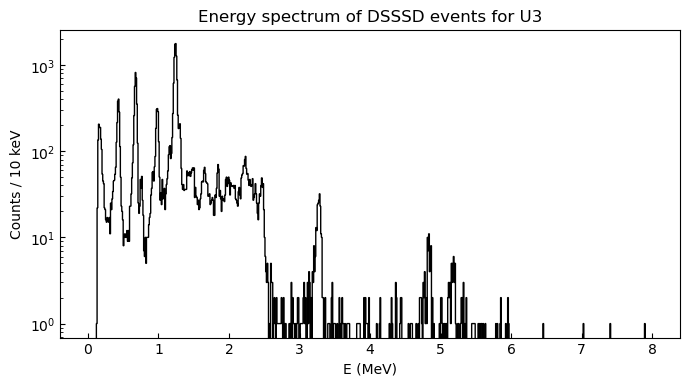

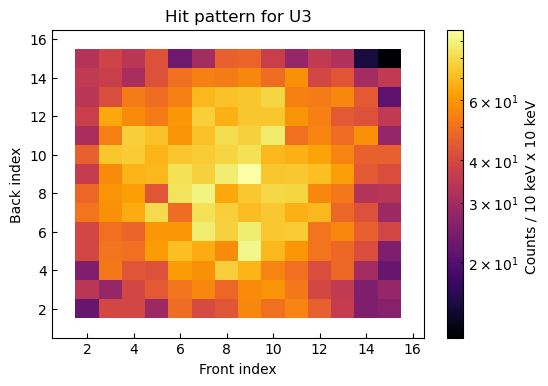

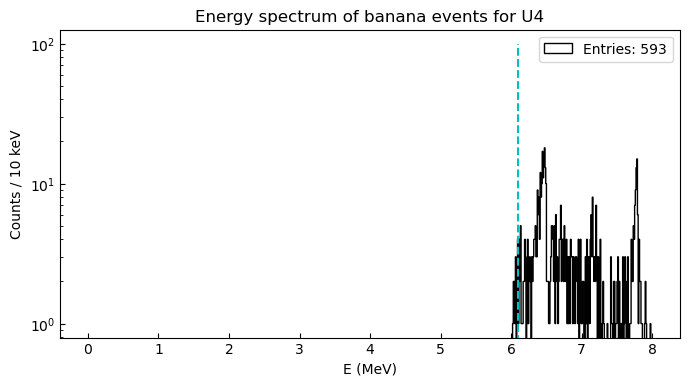

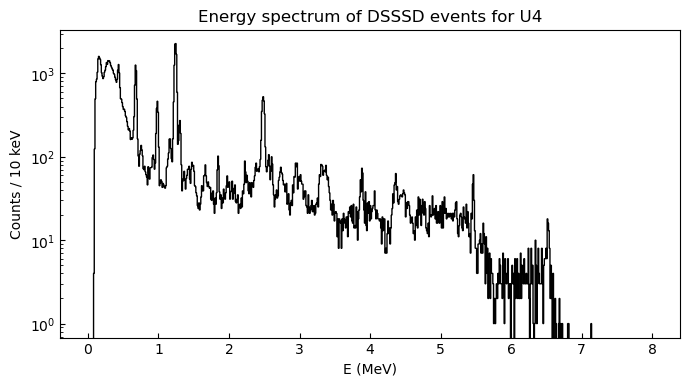

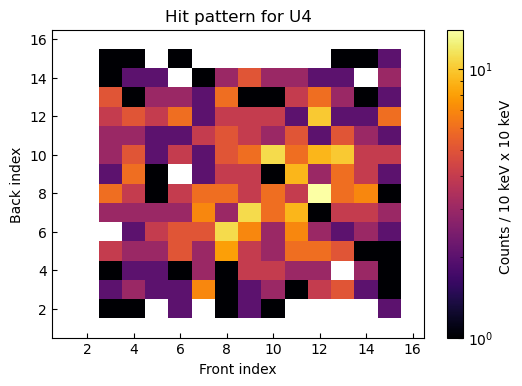

In [76]:
lims = [2.15, 2.5, 2.22, 6.1]

for i in range(4):
    det = f"id{i}"
    k = [a+b for a,b,c,d in zip(in_fedep[i],in_bedep[i], in_fi[i], in_bi[i])]
    plt.figure(figsize=(8,4))
    plt.hist(k, bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(k)}")
    plt.legend()
    plt.xlabel("E (MeV)")
    plt.title(f"Energy spectrum of banana events for U{i+1}")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    plt.vlines(lims[i], 0,1e2, color='c', ls='--')

    
    plt.figure(figsize=(8,4))
    ø = np.array(data_collection[iso][det]["Edep"])
    plt.hist(ø[ø>0], bins=np.arange(0,8, 0.01), histtype='step', color='k')

    plt.xlabel("E (MeV)")
    plt.title(f"Energy spectrum of DSSSD events for U{i+1}")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    
    plt.figure(figsize=(6,4))
    plt.hist2d(in_fi[i]-0.5, in_bi[i]-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for U{i+1}")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')

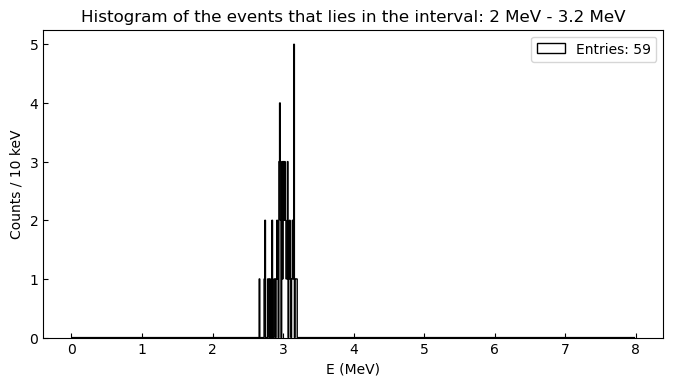

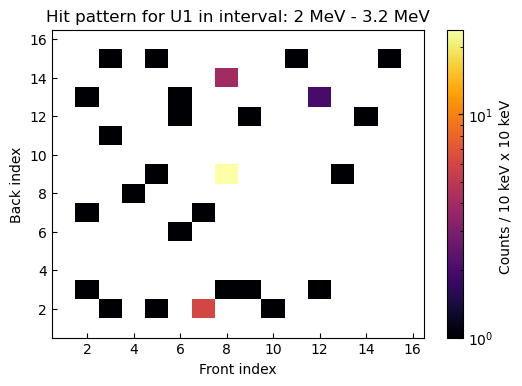

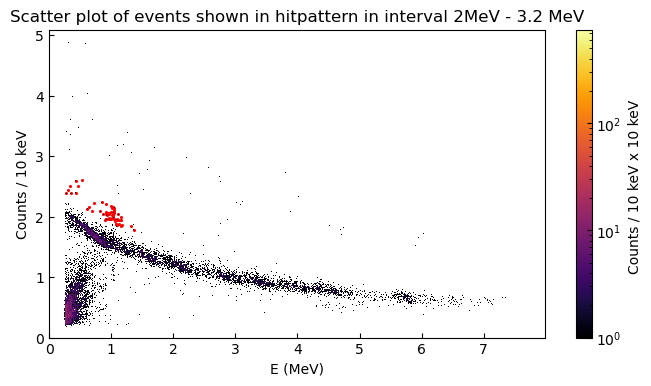

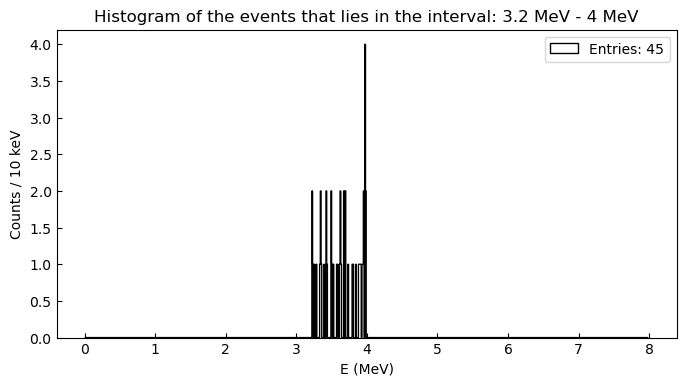

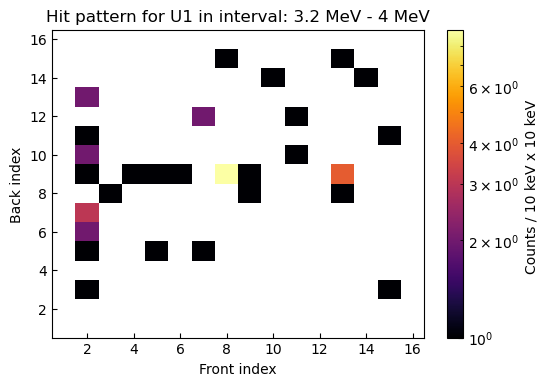

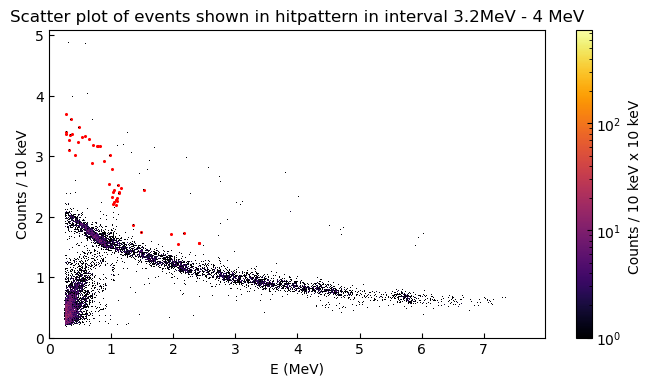

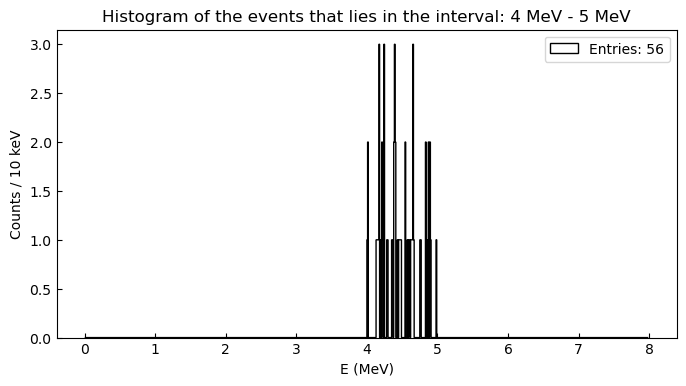

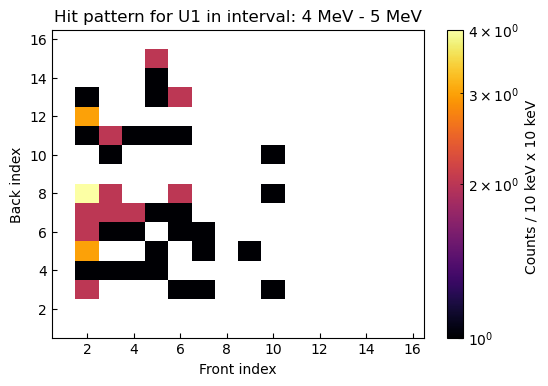

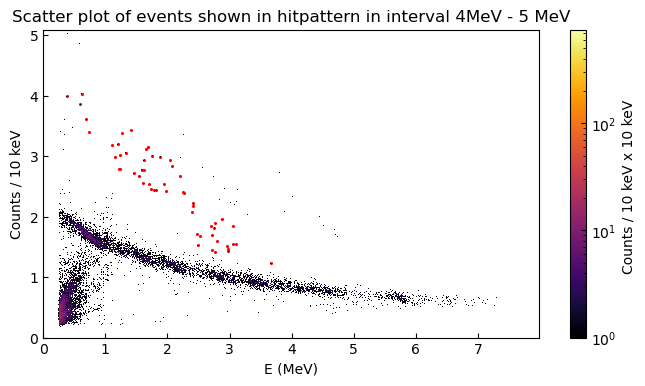

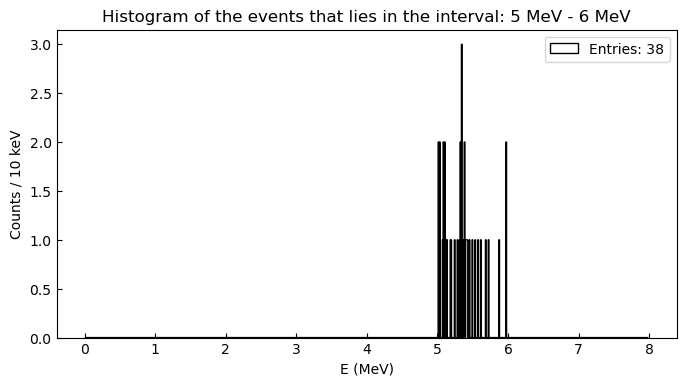

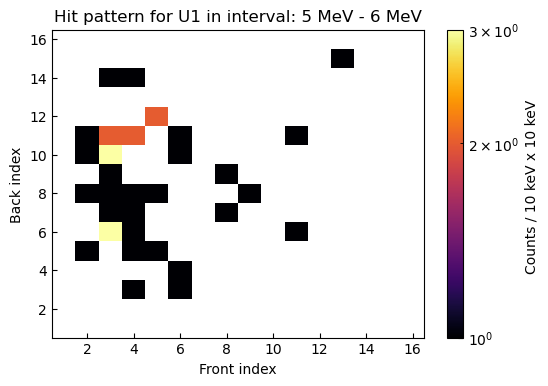

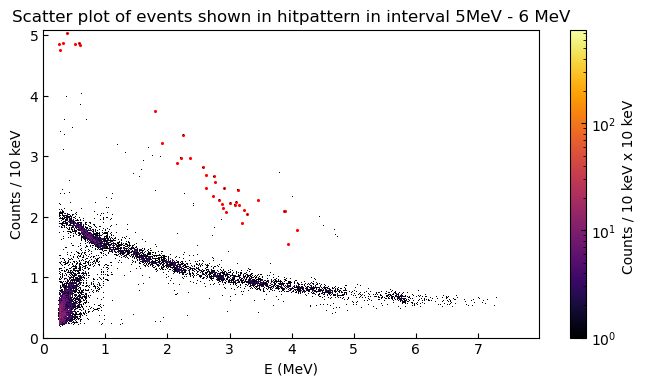

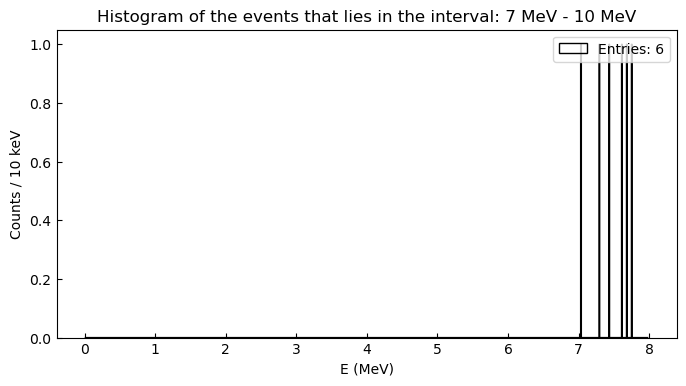

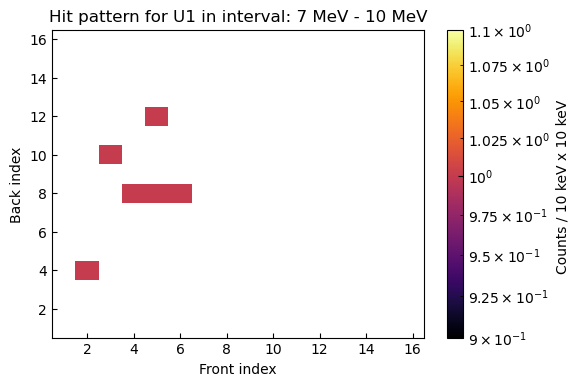

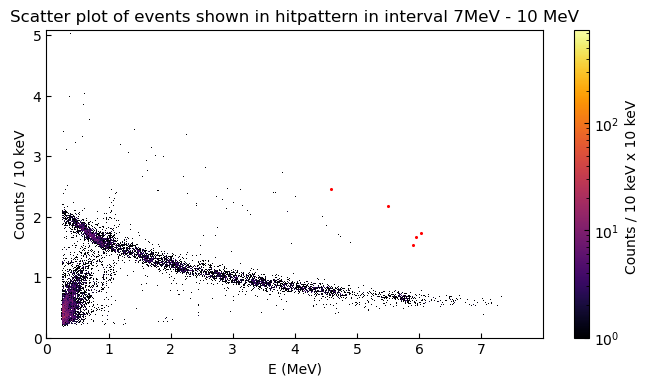

In [22]:
Eints = [(2,3.2),(3.2, 4),(4,5),(5,6),(7,10)]
for j in Eints:
    i = 0
    k = [a+b for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    plt.figure(figsize=(8,4))
    plt.hist(k, bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(k)}")
    plt.legend()
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.title(f"Histogram of the events that lies in the interval: {j[0]} MeV - {j[1]} MeV")
    plt.figure(figsize=(6,4))
    f = [c-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    b = [d-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for U{i+1} in interval: {j[0]} MeV - {j[1]} MeV")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    plt.figure(figsize=(8,4))
    g = [b for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    h = [a for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    plt.scatter(g, h, s=1.5, color='r')
    plt.hist2d(data_collection[iso]["id0"]["bEdep"], data_collection[iso]["id0"]["fEdep"], bins=(np.arange(0, 8, 0.01), np.arange(0, 5.1, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        
    plt.title(f"Scatter plot of events shown in hitpattern in interval {j[0]}MeV - {j[1]} MeV")
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")


864
485
491
173


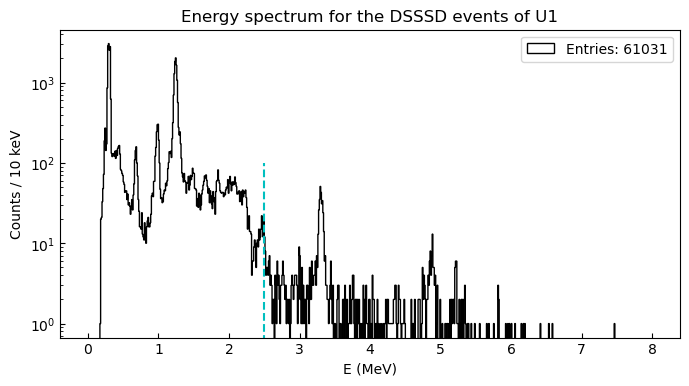

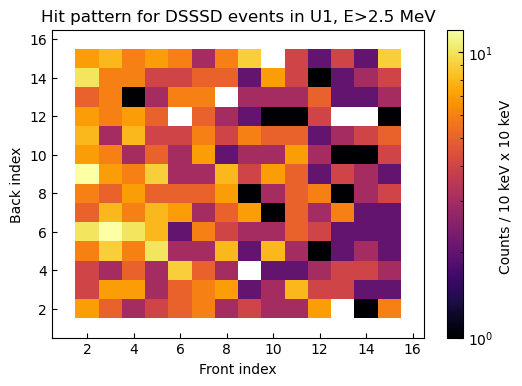

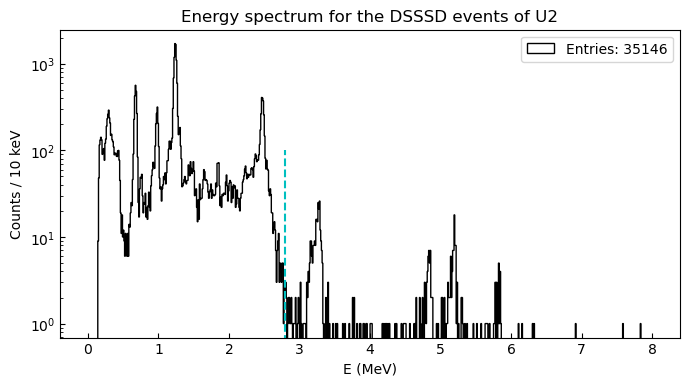

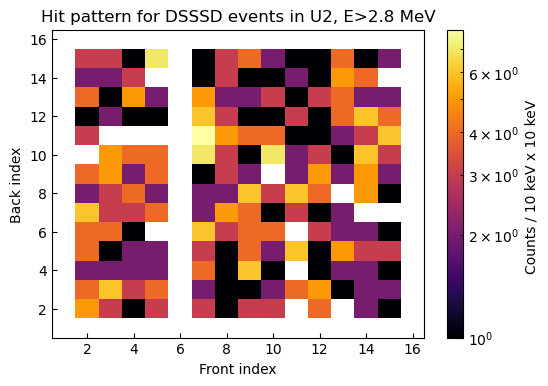

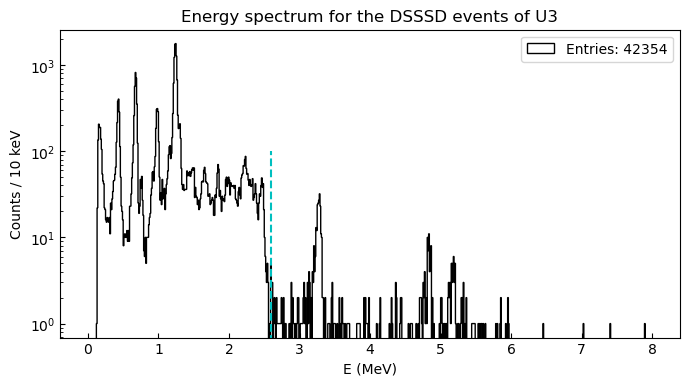

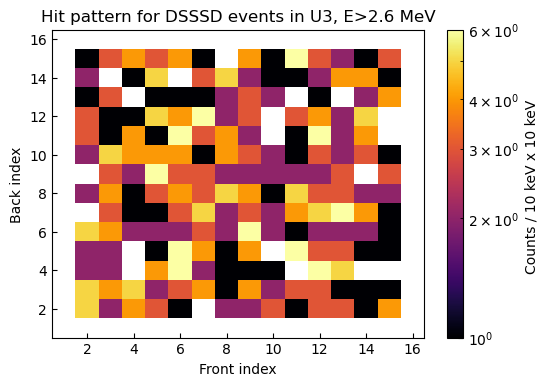

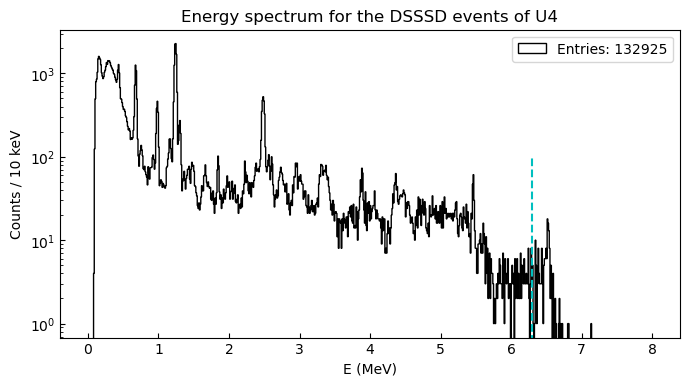

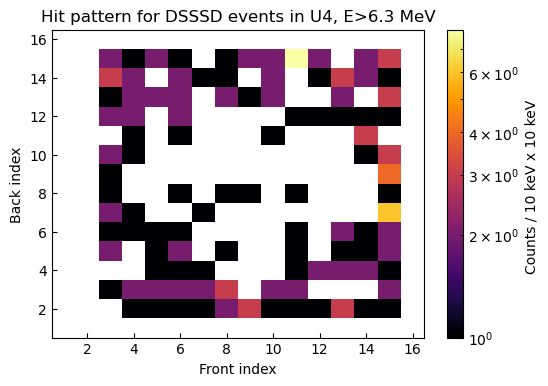

In [78]:
lims = [2.5, 2.8, 2.6, 6.3]
for i in range(4):
    det = f"id{i}"
    #k = [a+b for a,b,c in zip(above_fedep[i],above_bedep[i], above_fi[i]) if c<7]
#    k = [a for a,b,c in zip(data_collection[iso][det]["Edep"],data_collection[iso][det]["FI"],data_collection[iso][det]["BI"]) if 2.5<a<3.1]
    f = [b-0.5 for a,b,c in zip(data_collection[iso][det]["Edep"],data_collection[iso][det]["FI"],data_collection[iso][det]["BI"]) if lims[i]<a]
    b = [b-0.5 for a,b,c in zip(data_collection[iso][det]["Edep"],data_collection[iso][det]["BI"],data_collection[iso][det]["FI"]) if lims[i]<a]
    æ = np.array(data_collection[iso][det]["Edep"])
    plt.figure(figsize=(8,4))
    plt.hist(æ[æ>0], bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(æ)}")
    plt.vlines(lims[i], 0, 1e2, color='c', ls='--')
    plt.legend()
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    plt.title(f"Energy spectrum for the DSSSD events of U{i+1}")
    
    plt.figure(figsize=(6,4))
    plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for DSSSD events in U{i+1}, E>{lims[i]} MeV")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    print(len(f))

Text(0, 0.5, 'Back index')

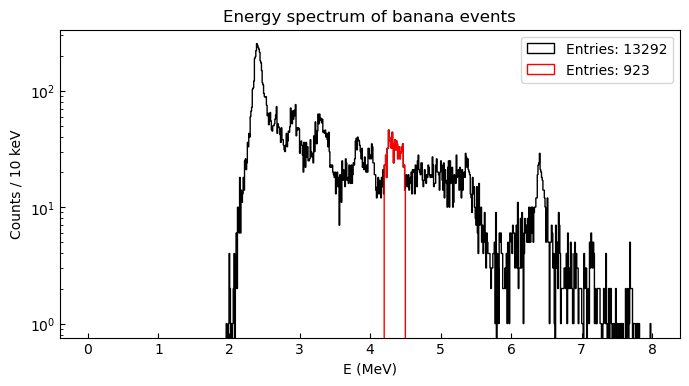

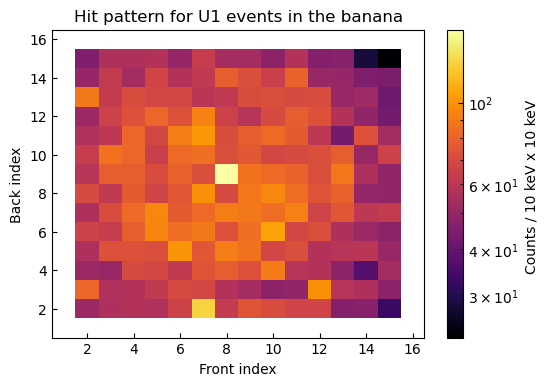

In [18]:
k = [a+b for a,b,c,d in zip(in_fedep[0],in_bedep[0], in_fi[0], in_bi[0])]
plt.figure(figsize=(8,4))
plt.hist(k, bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(k)}")
k = np.array(k)
e = k[(4.5>k) & (k>4.2)]
plt.hist(e, bins=np.arange(0,8, 0.01), histtype='step', color='r', label=f"Entries: {len(e)}")
plt.legend()
plt.xlabel("E (MeV)")
plt.ylabel("Counts / 10 keV")
plt.title("Energy spectrum of banana events")
plt.yscale('log')
plt.figure(figsize=(6,4))
plt.hist2d(in_fi[0]-0.5, in_bi[0]-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for U1 events in the banana")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')

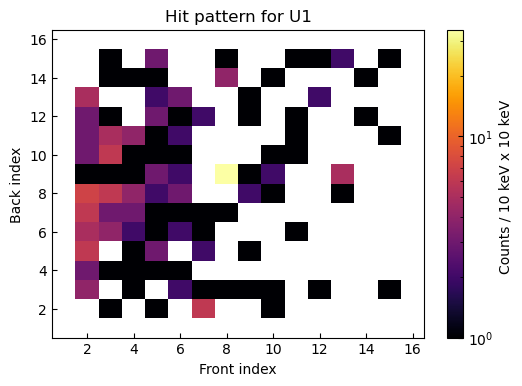

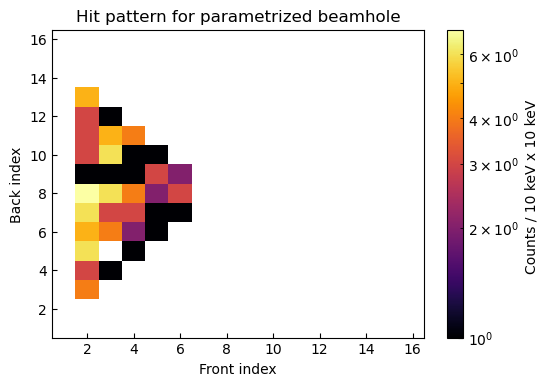

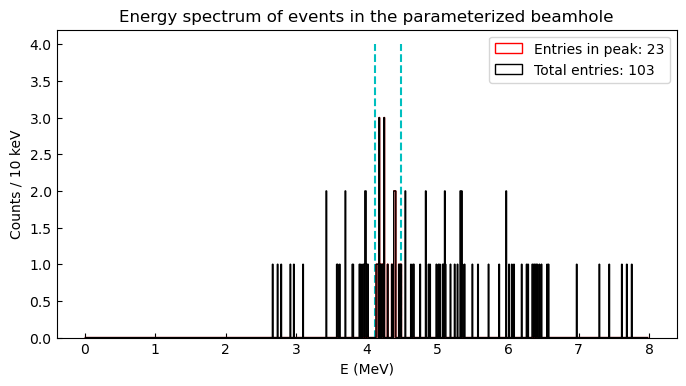

In [52]:
def solidangle(a, b, d, theta): ### a is the horizontal size, b is the vertical size
    theta = np.deg2rad(theta)
    a = a*np.cos(theta)
    strad = 4*np.arcsin( a*b / np.sqrt((a**2+4*d**2) * (b**2+4*d**2)))
    perc = strad/(4*np.pi) *100
    return perc

plt.figure(figsize=(6,4))
f = [c-0.5 for a,b,c,d in zip(above_fedep[0],above_bedep[0], above_fi[0], above_bi[0])]# and d!=9 and c!=8]
b = [d-0.5 for a,b,c,d in zip(above_fedep[0],above_bedep[0], above_fi[0], above_bi[0])]# and d!=9 and c!=8]
plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for U1")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')


plt.figure(figsize=(6,4))
fier = []; bier = []; fe=[]; be=[]
fis = [2,3,4,5,6,7]; bis=[(3,13), (4,12), (5,11), (6,10), (7,9), (8,8)]
for i,j in zip(fis,bis):
    for a,b,c,d in zip(above_fedep[0],above_bedep[0], above_fi[0], above_bi[0]):
        if c==i:
            if j[0]<=d<=j[1]:
                fier.append(c)
                bier.append(d)
                fe.append(a)
                be.append(b)

plt.hist2d(fier, bier, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for parametrized beamhole")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')

plt.figure(figsize=(8,4))
k = [a+b for a,b in zip(fe,be)]
k = np.array(k)
e = k[(4.49>k) & (k>4.12)]
plt.vlines(4.49, 0, 4, color='c', ls='--')
plt.vlines(4.12, 0, 4, color='c', ls='--')

plt.hist(e, bins=np.arange(0,8, 0.01), histtype='step', color='r', label=f"Entries in peak: {len(e)}")
plt.hist(k, bins=np.arange(0,8,0.01),histtype='step', color='k', label=f"Total entries: {len(k)}")
plt.title("Energy spectrum of events in the parameterized beamhole")
plt.xlabel("E (MeV)")
plt.ylabel("Counts / 10 keV")
plt.legend()
plt.show()

In [53]:
#Calculation of solid angle coverage of the parameterized strips in the previous hit pattern.
ext = [0.3, 0.93, 1.56, 2.17, 2.79, 3.41]
one = [1.23, 1.5, 1.78, 2.07, 2.36, 2.66, 2.96]
halfs = [0.74, 1.04, 1.33, 1.63, 1.94, 2.24, 2.55, 2.85]

solid_ones = []
for i,j in zip(ext,range(len(one))):
    dist = (one[j]+one[j+1])/2
    solid_ones.append(solidangle(0.3, i, dist, 45))

solid_halfs = []
for i,j in zip(ext,range(len(halfs))):
    dist = (halfs[j]+halfs[j+1])/2
    solid_halfs.append(solidangle(0.3, i, dist, 45))

print("Estimated solid angles for 1 cm: ",sum(solid_ones),"and for 0.5 cm: ",sum(solid_halfs)) ##5.4 for halfs & 3.4 for ones

### SOLID angle calculated from ERIKS SAM build with a modified target file to match what i've up to now calculated

SAM = np.loadtxt("/home/haue/repositories/Masters/setup/beamholeSAM.txt")
SAM #### first array holds all BI=1 FI's from 1 to 16 in that order and so on through the arrays
bs = [(3,13), (4,12), (5,11), (6,10), (7,9), (8,8)]
fs = [2,3,4,5,6,7]
ang = 0
for i in range(len(fs)):
    f = fs[i]
    for j in np.arange(bs[i][0], bs[i][1]+1, 1):
        ang += SAM[j][f] 

print("Solid angle coverage of the pixels of interest using Erik's SAM: ",np.rad2deg(ang)/360 *100, "%")

Estimated solid angles for 1 cm:  3.433031007804267 and for 0.5 cm:  5.417374763333065
Solid angle coverage of the pixels of interest using Erik's SAM:  2.9766435471239294 %


In [54]:
## Size of beamhole events compared to real events in the banana
p1 = (6.8/3.43 *len(e))/923 * 100
p2= (6.8/5.4 *len(e))/923 * 100
p3 = (6.8/2.976 *len(e))/923 *100 
p1,p2,p3

(4.940159007419714, 3.1379158139721515, 5.693798855997856)

193
284
72


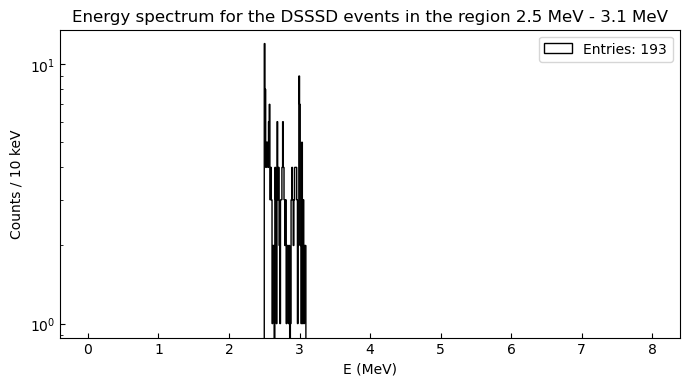

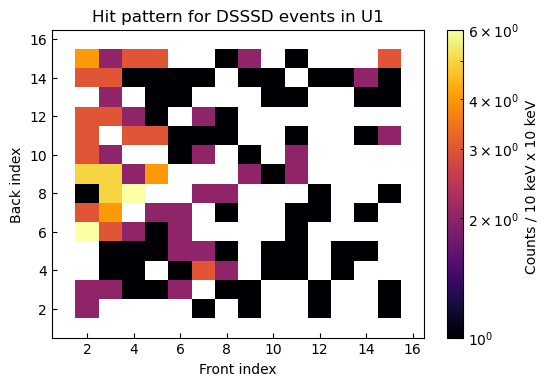

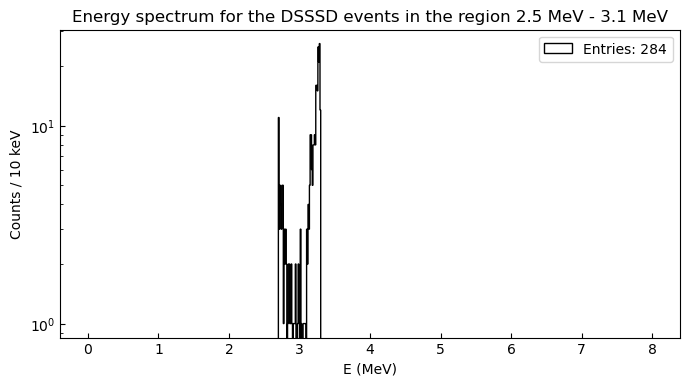

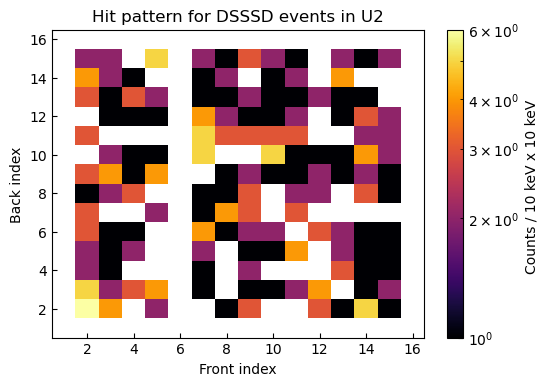

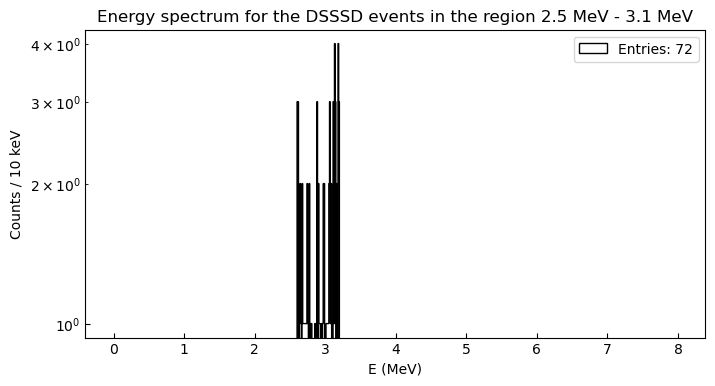

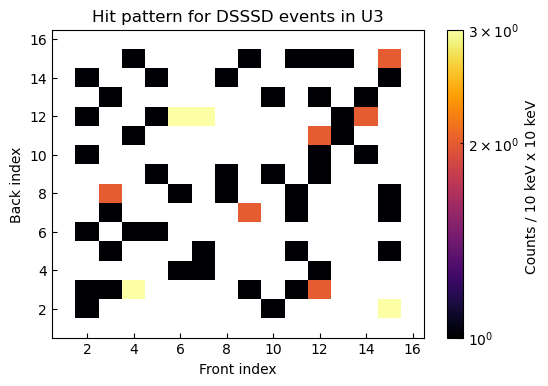

In [72]:
ls = [(2.5, 3.1), (2.7,3.3), (2.6,3.2)]
for i in range(3):
    det = f"id{i}"
    #k = [a+b for a,b,c in zip(above_fedep[i],above_bedep[i], above_fi[i]) if c<7]
    k = [a for a,b,c in zip(data_collection[iso][det]["Edep"],data_collection[iso][det]["FI"],data_collection[iso][det]["BI"]) if ls[i][0]<a<ls[i][1]]
    f = [b-0.5 for a,b,c in zip(data_collection[iso][det]["Edep"],data_collection[iso][det]["FI"],data_collection[iso][det]["BI"]) if ls[i][0]<a<ls[i][1]]
    b = [b-0.5 for a,b,c in zip(data_collection[iso][det]["Edep"],data_collection[iso][det]["BI"],data_collection[iso][det]["FI"]) if ls[i][0]<a<ls[i][1]]
    
    plt.figure(figsize=(8,4))
    plt.hist(k, bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(k)}")
    plt.legend()
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    plt.title("Energy spectrum for the DSSSD events in the region 2.5 MeV - 3.1 MeV")
    plt.figure(figsize=(6,4))
    plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for DSSSD events in U{i+1}")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    print(len(f))

In [ ]:
####Calculation of maximum angles for each strip when the distance is varied from 1 to 2 cm in steps of 0.5

## Distances to the strips in numerical order
# The values specifies the distance to the start of the strip that means the next value in the list, i+1,
# is the end value for the i'th strip. 
five = [1.725, 1.987, 2.25, 2.55, 2.82, 3.1, 3.4, 3.7]
one = [1.23, 1.5, 1.78, 2.07, 2.36, 2.66, 2.96, 3.26]
#halfs = [0.74, 1.04, 1.33, 1.63, 1.94, 2.24, 2.55, 2.85]
twos = [2.23,2.4775,2.7377,3,3.285,3.567,3.85,4.14]
five_t = [52,57,62,65,68,70,72,73.4] # calculated angles for the start of the strip
one_t = [55,62,67,70,73,74.5,76,77.5] # This means that the start value of, for example FI=3 is the end value of FI=2
twos_t = [50.5,55,59,62,64.5,67,68.5,70]
two = 2.2 ### distance from center to farthest BI pixel within the same FI strip
d1 = []; d2 = []; d3 = []; x1 = []; x2 = []; x3 = []; h1=[]; h2=[]; h3=[]; ang1=[]; ang2=[]; ang3=[]
for i,j,k in zip(five,one,twos):
    #d1.append(np.round(np.sqrt(i**2+two**2),3))
    #d2.append(np.round(np.sqrt(j**2+two**2),3))
    #d3.append(np.round(np.sqrt(k**2+two**2),3))
    d1.append(np.sqrt(i**2+two**2))
    d2.append(np.sqrt(j**2+two**2))
    d3.append(np.sqrt(k**2+two**2))
def xs(theta, c):
    return np.cos(np.deg2rad(90-theta))*c
for i1,i2,j1,j2,k1,k2 in zip(five_t,five,one_t,one,twos_t,twos):
    #x1.append(np.round(xs(i1,i2),3))
    #x2.append(np.round(xs(j1,j2),3))
    #x3.append(np.round(xs(k1,k2),3))
    x1.append(xs(i1,i2))
    x2.append(xs(j1,j2))
    x3.append(xs(k1,k2))
for i,j,k in zip(x1,x2,x3):
    #h1.append(np.round(np.sqrt(2.2**2+i**2),3))
    #h2.append(np.round(np.sqrt(2.2**2+j**2),3))
    #h3.append(np.round(np.sqrt(2.2**2+k**2),3))
    h1.append(np.sqrt(2.2**2+i**2))
    h2.append(np.sqrt(2.2**2+j**2))
    h3.append(np.sqrt(2.2**2+k**2))
def angle(d,h):
    return np.rad2deg(np.arcsin(h/d))
for i1,i2,j1,j2,k1,k2 in zip(h1,d1,h2,d2,h3,d3):
    ang1.append(np.round(angle(i2,i1),2))
    ang2.append(np.round(angle(j2,j1),2))
    ang3.append(np.round(angle(k2,k1),2))

#print("d1: ", d1)
#print("d2: ", d2)
#print("d3: ", d3)
#print("x1: ",x1)
#print("x2: ",x2)
#print("x3: ",x3)
#print("h1: ",h1)
#print("h2: ",h2)
#print("h3: ",h3)

print("at 1   cm away ang2: ",ang2)
print("at 1.5 cm away ang1: ",ang1)
print("at 2   cm away ang3: ",ang3)

at 1   cm away ang2:  [73.75, 74.66, 75.77, 76.45, 77.65, 78.12, 78.8, 79.66]
at 1.5 cm away ang1:  [67.67, 68.59, 70.39, 71.34, 72.82, 73.8, 74.96, 75.79]
at 2   cm away ang3:  [63.08, 64.6, 66.33, 67.75, 69.04, 70.58, 71.45, 72.42]


In [17]:
### Solid angle for experimental setup, pretty much agrees with the values stated in Eriks Phd
# But only if the distance between U1 & P1 is 5.3 mm as stated in the thesis and not calculated from the setup file   
frontsolid = solidangle(0.3, 4.95, 4.24, 0)
telesolid = solidangle(4.95, 4.95, 4.78, 0)
print(frontsolid, telesolid)


0.567367624317074 6.780807030541522


Peak intervals:  (1.1, 1.38) (2.32, 2.62) (2.86, 3.12) (3.2, 3.5) (3.78, 4) (4.26, 4.6) (5.4, 5.52)

Telescope 1 counts for each of the peaks: [14045, 4065, 1336, 1617, 635, 1046, 263]

Telescope 2 counts for each of the peaks: [9528, 3582, 1035, 1193, 518, 896, 244]

Telescope 3 counts for each of the peaks: [9849, 3149, 1100, 1278, 575, 884, 229]

Telescope 4 counts for each of the peaks:  0000, 0000, 0000, 0000 [758, 1127, 267]

Difference in % between 1 and 2 is:  [27.0, 5.0, 17.0, 21.0, 12.0, 8.0, 0.0]
Difference in % between 1 and 3 is:  [30.0, 23.0, 18.0, 21.0, 9.0, 15.0, 13.0]

Difference in % between 4 and 2 is:  ['00', '00', '00', '00'] [37.0, 27.0, 16.0]
Difference in % between 4 and 3 is:  ['00', '00', '00', '00'] [35.0, 33.0, 26.0]

Difference in % between 4 and 1 is:  ['00', '00', '00', '00'] [28.0, 20.0, 16.0]
Difference in % between 2 and 3 is:  [4.0, 18.0, 1.0, 1.0, -3.0, 8.0, 13.0]


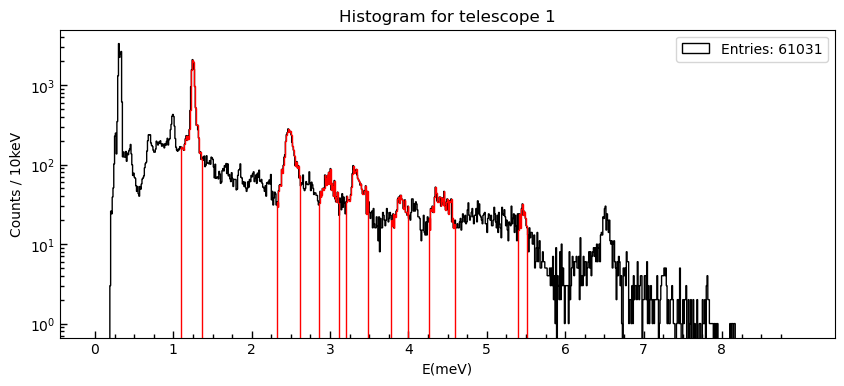

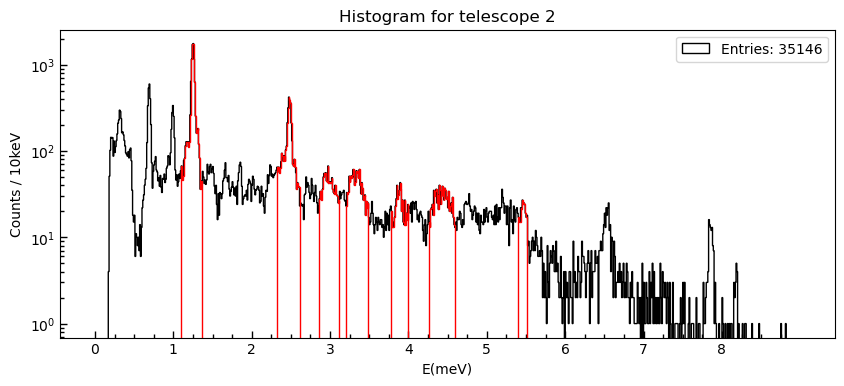

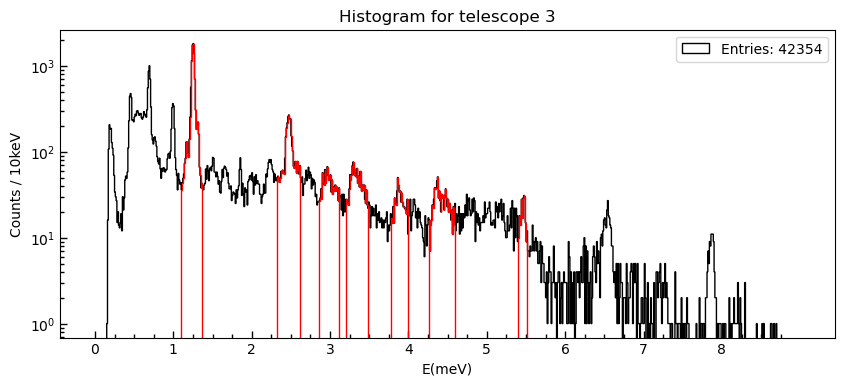

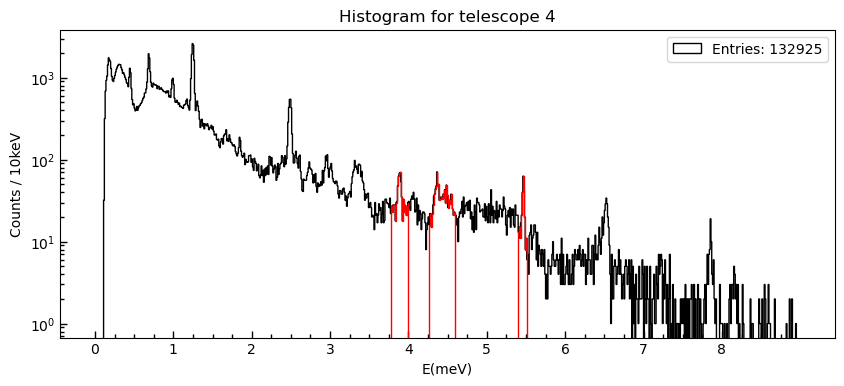

In [77]:

## looking at E & Edep
## Start by only looking at events that have been telescope "verified"
# This means that our data does not contain counts from delta contained events.
#This should also take into account the alpha peaks actually...

peak_intervals = [(1.1, 1.38), (2.32, 2.62), (2.86, 3.12), (3.2, 3.5), (3.78, 4),(4.26, 4.6),
                  (5.4, 5.52)]

id3peaks = peak_intervals[4:]
counts = [[[] for _ in range(len(peak_intervals))] for _ in range(3)]
counts_id3 = [[] for _ in range(len(id3peaks))]

bin_width = 0.01 #keV

for i in range(4):
    det = f"id{i}"
    bins = np.arange(0, 9, bin_width)
    plt.figure(figsize=(10,4))
    e = np.array(data_collection[iso][det]["E"])
    plt.hist(e, bins=bins, histtype='step', color='k', label=f"Entries: {len(e)}")
    plt.legend()
    if(i==3):
        for int, j in zip(id3peaks, range(len(id3peaks))):
            e_peak = e[(e>int[0]) & (e<int[1])]
            counts_id3[j] = len(e_peak)
            bins = np.arange(int[0], int[1], bin_width)
            plt.hist(e_peak, bins=bins, histtype='step', color='r')
            
    else:
        for int, j in zip(peak_intervals, range(len(peak_intervals))):
            e_peak = e[(e>int[0]) & (e<int[1])]
            counts[i][j] = len(e_peak)
            bins = np.arange(int[0], int[1], bin_width)
            plt.hist(e_peak, bins=bins, histtype='step', color='r')
    plt.title(f"Histogram for telescope {i+1}")
    plt.yscale('log')
    plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
    plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
    plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
    plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
    plt.gca().set_xticks(np.arange(0, 9, 0.25), minor=True)
    plt.xticks(np.arange(0,9,1))
    plt.ylabel("Counts / 10keV")
    plt.xlabel("E(meV)")

print("Peak intervals: ", *peak_intervals)
print()

for i in range(0,4):
    if(i==3):
         print(f"Telescope {i+1} counts for each of the peaks: ",
               "0000, 0000, 0000, 0000", [j for j in counts_id3])
    else:        
        print(f"Telescope {i+1} counts for each of the peaks:",
          [j for j in counts[i]])
        print()
        
counts[1] = [i*14/13 for i in counts[1]]
counts_id3 = [i*14/12 for i in counts_id3]

print()
print("Difference in % between 1 and 2 is: ", [np.round((i-j)/i*100) for i,j in zip(counts[0],counts[1])])
print("Difference in % between 1 and 3 is: ", [np.round((i-j)/i*100) for i,j in zip(counts[0],counts[2])])
print()
print("Difference in % between 4 and 2 is: ", ["00", "00", "00", "00"], [np.round((i-j)/i*100) for i,j in zip(counts_id3,counts[1][4:])])
print("Difference in % between 4 and 3 is: ", ["00", "00", "00", "00"], [np.round((i-j)/i*100) for i,j in zip(counts_id3,counts[2][4:])])
print()
print("Difference in % between 4 and 1 is: ", ["00", "00", "00", "00"], [np.round((i-j)/i*100) for i,j in zip(counts_id3,counts[0][4:])])
print("Difference in % between 2 and 3 is: ", [np.round((i-j)/i*100) for i,j in zip(counts[1],counts[2])])


Solid angle coverage of the pixels of interest:  2.9766435471239294 %
